# logistic regression for multi class classification

* As we know logistic regerssion cannot do multiclass classification
* But we have two options Multinomial and OVR options through which we can perform  multi class classification in logistic regression

## Differences can be summarized like this:

### Training: 

> the softmax regression model uses the cross entropy cost function, while the OvR "composite" model based on multiple binary logistic regressors trains completely independent binary logit classifiers using the logistic regression cost function.

### Trained model representation:

> not much difference - in softmax each class gets its own parameter vector, and these vectors are stored together in a common parameter matrix, while in OvR logit there are exactly as many separate parameter vectors, one for each positive class.


### Evaluation: 

> >the softmax regression model uses the softmax function that predicts a probability for each class considering the scores for other classes, while the OvR "composite" model based on multiple binary logistic regressors calculates the scores/probabilities of classes completely independently and then just picks the label with the highest score.
It also seems that there was no need to explain the differences between the binary, the OvR/OvO "composite" models and the "native" multilabel classifiers like the multinomial logistic regressor (aka the softmax regressor).

* The softmax regression (LogisticRegression(multi_class="multinomial") in scikit-learn) is more flexible when setting the linear decision boundaries among the classes.

# lets import neccesary libraries

In [40]:
import pandas as pd
import numpy as np
from sklearn.metrics import accuracy_score, f1_score, roc_auc_score,log_loss,confusion_matrix
from  sklearn.model_selection import train_test_split
from imblearn.combine import SMOTETomek
import matplotlib.pyplot as plt
import seaborn as sns
import pickle
import warnings
warnings.filterwarnings("ignore")
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV

# Lets Download the cancer data from kaggle

In [2]:
!pip install -q kaggle
from google.colab import files
files.upload()
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 /root/.kaggle/kaggle.json
!mkdir cancerdata
!kaggle datasets download -d rishidamarla/cancer-patients-data
!unzip cancer-patients-data.zip -d cancerdata

Saving kaggle.json to kaggle.json
  0% 0.00/68.6k [00:00<?, ?B/s]
100% 68.6k/68.6k [00:00<00:00, 27.9MB/s]
Archive:  cancer-patients-data.zip
  inflating: cancerdata/cancer patient data sets.xlsx  


# Lets load the dataset

In [4]:
cancerdata = pd.read_excel('/content/cancerdata/cancer patient data sets.xlsx')
cancerdata.head()

,Patient Id,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,...,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring,Level
0,P1,33,1,2,4,5,4,3,2,2,...,3,4,2,2,3,1,2,3,4,Low
1,P10,17,1,3,1,5,3,4,2,2,...,1,3,7,8,6,2,1,7,2,Medium
2,P100,35,1,4,5,6,5,5,4,6,...,8,7,9,2,1,4,6,7,2,High
3,P1000,37,1,7,7,7,7,6,7,7,...,4,2,3,1,4,5,6,7,5,High
4,P101,46,1,6,8,7,7,7,6,7,...,3,2,4,1,4,2,4,2,3,High


In [5]:
cancerdata.columns

Index(['Patient Id', 'Age', 'Gender', 'Air Pollution', 'Alcohol use',
       'Dust Allergy', 'OccuPational Hazards', 'Genetic Risk',
       'chronic Lung Disease', 'Balanced Diet', 'Obesity', 'Smoking',
       'Passive Smoker', 'Chest Pain', 'Coughing of Blood', 'Fatigue',
       'Weight Loss', 'Shortness of Breath', 'Wheezing',
       'Swallowing Difficulty', 'Clubbing of Finger Nails', 'Frequent Cold',
       'Dry Cough', 'Snoring', 'Level'],
      dtype='object')

In [8]:
#for column in list(cancerdata.columns):
#  print('********* '+str(column) + " **********")
#  print(cancerdata[column].value_counts())
# As all features are ordinal we can keep then as it is

In [10]:
# null value check
cancerdata.isnull().sum()
# No null values

Patient Id                  0
Age                         0
Gender                      0
Air Pollution               0
Alcohol use                 0
Dust Allergy                0
OccuPational Hazards        0
Genetic Risk                0
chronic Lung Disease        0
Balanced Diet               0
Obesity                     0
Smoking                     0
Passive Smoker              0
Chest Pain                  0
Coughing of Blood           0
Fatigue                     0
Weight Loss                 0
Shortness of Breath         0
Wheezing                    0
Swallowing Difficulty       0
Clubbing of Finger Nails    0
Frequent Cold               0
Dry Cough                   0
Snoring                     0
Level                       0
dtype: int64

In [12]:
# data balance check
cancerdata.Level.value_counts()
# data almost balanced so no issue

High      365
Medium    332
Low       303
Name: Level, dtype: int64

In [56]:
cancerdata.iloc[:,1:-1].corr()

,Age,Gender,Air Pollution,Alcohol use,Dust Allergy,OccuPational Hazards,Genetic Risk,chronic Lung Disease,Balanced Diet,Obesity,...,Coughing of Blood,Fatigue,Weight Loss,Shortness of Breath,Wheezing,Swallowing Difficulty,Clubbing of Finger Nails,Frequent Cold,Dry Cough,Snoring
Age,1.000000,-0.202086,0.099494,0.151742,0.035202,0.062177,0.073151,0.128952,0.004863,0.034337,...,0.053006,0.095059,0.106946,0.035329,-0.095354,-0.105833,0.039258,-0.012706,0.012128,-0.004700
Gender,-0.202086,1.000000,-0.246912,-0.227636,-0.204312,-0.192343,-0.222727,-0.205061,-0.099741,-0.123813,...,-0.146505,-0.116467,-0.057993,-0.045972,-0.076304,-0.058324,-0.034219,-0.000526,-0.123001,-0.181618
Air Pollution,0.099494,-0.246912,1.000000,0.747293,0.637503,0.608924,0.705276,0.626701,0.524873,0.601468,...,0.607829,0.211724,0.258016,0.269558,0.055368,-0.080918,0.241065,0.174539,0.261489,-0.021343
Alcohol use,0.151742,-0.227636,0.747293,1.000000,0.818644,0.878786,0.877210,0.763576,0.653352,0.669312,...,0.667612,0.237245,0.207851,0.435785,0.180817,-0.114073,0.414992,0.180778,0.211277,0.122694
Dust Allergy,0.035202,-0.204312,0.637503,0.818644,1.000000,0.835860,0.787904,0.619556,0.647197,0.700676,...,0.625291,0.332472,0.321756,0.518682,0.304850,0.031141,0.345714,0.219389,0.300195,0.052844
OccuPational Hazards,0.062177,-0.192343,0.608924,0.878786,0.835860,1.000000,0.893049,0.858284,0.691509,0.722191,...,0.645947,0.267844,0.176226,0.366482,0.178925,-0.002853,0.366447,0.077166,0.159887,0.022916
Genetic Risk,0.073151,-0.222727,0.705276,0.877210,0.787904,0.893049,1.000000,0.836231,0.679905,0.729826,...,0.632236,0.230530,0.271743,0.458200,0.204973,-0.062948,0.357815,0.087092,0.194399,-0.056831
chronic Lung Disease,0.128952,-0.205061,0.626701,0.763576,0.619556,0.858284,0.836231,1.000000,0.622632,0.601754,...,0.602987,0.247697,0.104080,0.182426,0.057214,0.007279,0.298023,0.028759,0.114161,0.043375
Balanced Diet,0.004863,-0.099741,0.524873,0.653352,0.647197,0.691509,0.679905,0.622632,1.000000,0.706922,...,0.745054,0.400678,-0.006544,0.343623,0.063930,0.046807,0.041967,0.263931,0.331995,0.152677
Obesity,0.034337,-0.123813,0.601468,0.669312,0.700676,0.722191,0.729826,0.601754,0.706922,1.000000,...,0.814805,0.552788,0.313495,0.406203,0.094287,0.127213,0.149093,0.288368,0.200618,0.039422


In [55]:
from statsmodels.stats.outliers_influence import variance_inflation_factor
vif = pd.DataFrame()
vif["features"] = pd.DataFrame(cancerdata.iloc[:,1:-1]).columns
vif["vif_Factor"] = [variance_inflation_factor(cancerdata.iloc[:,1:-1].values, i) for i in range(cancerdata.iloc[:,1:-1].shape[1])]
vif

,features,vif_Factor
0,Age,8.878553
1,Gender,7.229196
2,Air Pollution,18.730416
3,Alcohol use,53.488354
4,Dust Allergy,50.521043
5,OccuPational Hazards,124.714056
6,Genetic Risk,112.607021
7,chronic Lung Disease,58.049623
8,Balanced Diet,38.343194
9,Obesity,42.431869


In [29]:
X = cancerdata.iloc[:,1:-1]
y = cancerdata.iloc[:,[-1]]
y.Level = y.Level.map({'Low':0,"Medium":1,"High":2})

In [31]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2, stratify = y)
print(X_train.shape)
print(X_test.shape)
print(y_train.shape)
print(y_test.shape)

(800, 23)
(200, 23)
(800, 1)
(200, 1)


# Lets apply Logistic Regression in MULTINOMIAL setting

In [62]:
parameters = {'C': (0.1,0.001,1.0,10.0,100.0),'multi_class' : ['multinomial']}
model = GridSearchCV(LogisticRegression(), parameters,refit = True, scoring = 'accuracy',return_train_score = True)
model.fit(X_train,y_train)
#print(model.cv_results_)
print(model.best_estimator_)
print(model.best_score_)

LogisticRegression(multi_class='multinomial')
0.99375


In [63]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)


accuracy score : 0.985
f1 score : 0.9850037237013592


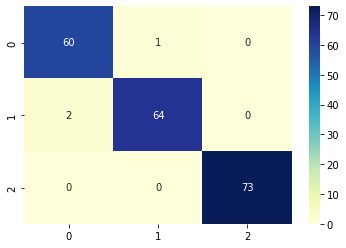

In [64]:
print("accuracy score :",accuracy_score(y_test,y_pred))
print("f1 score :",f1_score(y_test,y_pred, average = 'weighted'))
#print('Confusion matrix :',confusion_matrix(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True,cmap="YlGnBu")


# Lets use One Vs Rest Approach

In [50]:
parameters = {'C': (0.1,0.001,1.0,10.0,100.0),'multi_class' : ['ovr']}
model = GridSearchCV(LogisticRegression(), parameters,refit = True, scoring = 'accuracy',return_train_score = True)
model.fit(X_train,y_train)
#print(model.cv_results_)
print(model.best_estimator_)
print(model.best_score_)

LogisticRegression(C=100.0, multi_class='ovr')
0.9925


In [51]:
y_pred = model.predict(X_test)
y_prob = model.predict_proba(X_test)

accuracy score : 0.985
f1 score : 0.9850037237013592


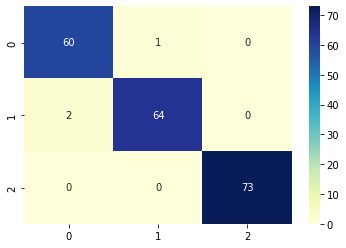

In [52]:
print("accuracy score :",accuracy_score(y_test,y_pred))
print("f1 score :",f1_score(y_test,y_pred, average = 'weighted'))
#print('Confusion matrix :',confusion_matrix(y_test, y_pred))
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True,cmap="YlGnBu")